In [25]:
import numpy as np
import corner

In [133]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = plt.cm.get_cmap('viridis_r')
#cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

## Load data

In [206]:
betas = np.load("../data/betas.npy")
hods = np.load("../data/hods.npy")[:, :-2]
fit_betas = np.load("../data/fit_betas_P+B.npy").T

betas.shape, hods.shape, fit_betas.shape

((10500, 5, 127), (10500, 8), (10500, 6))

## Train density estimators

In [207]:
import torch

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from tqdm import tqdm

In [208]:
val_fraction = 0.05

# Get train and validation sets
n_samples = len(fit_betas)
n_val = int(val_fraction * n_samples)
n_train = n_samples - n_val

# Shuffle data
shuffler = np.random.permutation(n_samples)
fit_betas = fit_betas[shuffler]
hods = hods[shuffler]

X_train = torch.tensor(fit_betas[:n_train], dtype=torch.float32)
Y_train = torch.tensor(hods[:n_train], dtype=torch.float32)

X_val = torch.tensor(fit_betas[n_train:], dtype=torch.float32)
Y_val = torch.tensor(hods[n_train:], dtype=torch.float32)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([9975, 6]),
 torch.Size([9975, 8]),
 torch.Size([525, 6]),
 torch.Size([525, 8]))

In [209]:
import torch.nn.functional as F

def get_flow(d_in=2, d_context=12, d_hidden=32, n_layers=4, dropout=0.1):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, 
                                                              hidden_features=d_hidden,
                                                              context_features=d_context,
                                                              use_residual_blocks=True,
                                                              dropout_probability=dropout,
                                                              activation=F.gelu))
        
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

In [210]:
def train_flow(flow, X, Y, X_val, Y_val, batch_size=64, n_steps=5001, n_eval_every=100, lr = 1e-3):
    """ Convenience function for training the normalizing flow transformation
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

    loss_train = []
    
    loss_train_accum = []
    loss_val_accum = []
    steps_accum = []

    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = np.random.choice(X.shape[0], batch_size) 
        if Y is not None:
            loss = -flow.log_prob(X[idxs,:], Y[idxs,:]).mean()
        else:
            loss = -flow.log_prob(X[idxs,:]).mean()

        loss.backward()
        optimizer.step()

        # Store loss
        loss_train.append(loss.item())

        # Print progress and validation loss
        if i_step % n_eval_every == 0:
            if Y is not None:
                loss_val = -flow.log_prob(X_val, Y_val).mean()
            else:
                loss_val = -flow.log_prob(X_val).mean()

            loss_train_accum.append(np.mean(loss_train))
            loss_val_accum.append(loss_val.item())
            steps_accum.append(i_step)

            print(f"Step {i_step}, loss: {np.mean(loss_train):.2f}, val loss: {loss_val.item():.2f}")

            loss_train = []

    return steps_accum, loss_train_accum, loss_val_accum
        

## $p(\beta\mid\mathrm{HOD})$

In [211]:
d_in = X_train.shape[-1]
d_context = Y_train.shape[-1]

flow = get_flow(d_in=d_in, d_context=d_context, d_hidden=128, n_layers=6, dropout=0.1)

In [212]:
steps_accum, loss_train_accum, loss_val_accum = train_flow(flow, X_train, Y_train, X_val, Y_val, batch_size=128, n_steps=30001, n_eval_every=200, lr=3e-4)

  0%|          | 10/30001 [00:00<09:54, 50.45it/s]

Step 0, loss: 45.17, val loss: 35.67


  1%|          | 214/30001 [00:03<07:24, 67.07it/s]

Step 200, loss: 1.35, val loss: -2.79


  1%|▏         | 410/30001 [00:05<06:57, 70.86it/s]

Step 400, loss: -4.02, val loss: -5.49


  2%|▏         | 608/30001 [00:08<07:07, 68.81it/s]

Step 600, loss: -5.61, val loss: -6.31


  3%|▎         | 811/30001 [00:11<07:08, 68.13it/s]

Step 800, loss: -6.42, val loss: -6.59


  3%|▎         | 1010/30001 [00:14<06:49, 70.72it/s]

Step 1000, loss: -6.78, val loss: -7.21


  4%|▍         | 1211/30001 [00:17<08:12, 58.47it/s]

Step 1200, loss: -7.29, val loss: -7.90


  5%|▍         | 1412/30001 [00:20<06:46, 70.30it/s]

Step 1400, loss: -7.51, val loss: -7.22


  5%|▌         | 1610/30001 [00:23<06:36, 71.53it/s]

Step 1600, loss: -7.88, val loss: -7.93


  6%|▌         | 1810/30001 [00:25<06:44, 69.64it/s]

Step 1800, loss: -8.07, val loss: -8.49


  7%|▋         | 2010/30001 [00:28<06:29, 71.83it/s]

Step 2000, loss: -8.35, val loss: -8.90


  7%|▋         | 2210/30001 [00:31<06:23, 72.51it/s]

Step 2200, loss: -8.56, val loss: -9.30


  8%|▊         | 2410/30001 [00:34<06:21, 72.27it/s]

Step 2400, loss: -8.81, val loss: -9.21


  9%|▊         | 2610/30001 [00:36<06:22, 71.52it/s]

Step 2600, loss: -8.95, val loss: -9.45


  9%|▉         | 2810/30001 [00:39<06:29, 69.87it/s]

Step 2800, loss: -9.08, val loss: -9.54


 10%|█         | 3010/30001 [00:42<06:15, 71.84it/s]

Step 3000, loss: -9.16, val loss: -9.21


 11%|█         | 3210/30001 [00:45<06:15, 71.37it/s]

Step 3200, loss: -9.36, val loss: -9.18


 11%|█▏        | 3410/30001 [00:47<06:23, 69.40it/s]

Step 3400, loss: -9.51, val loss: -9.94


 12%|█▏        | 3610/30001 [00:50<06:07, 71.91it/s]

Step 3600, loss: -9.60, val loss: -10.13


 13%|█▎        | 3810/30001 [00:53<06:04, 71.89it/s]

Step 3800, loss: -9.72, val loss: -10.34


 13%|█▎        | 4010/30001 [00:56<06:01, 71.92it/s]

Step 4000, loss: -9.88, val loss: -9.94


 14%|█▍        | 4210/30001 [00:58<06:09, 69.82it/s]

Step 4200, loss: -9.90, val loss: -9.06


 15%|█▍        | 4410/30001 [01:01<06:00, 70.95it/s]

Step 4400, loss: -9.98, val loss: -10.45


 15%|█▌        | 4610/30001 [01:04<05:51, 72.26it/s]

Step 4600, loss: -10.08, val loss: -10.27


 16%|█▌        | 4810/30001 [01:07<05:51, 71.71it/s]

Step 4800, loss: -10.07, val loss: -10.27


 17%|█▋        | 5010/30001 [01:09<05:48, 71.68it/s]

Step 5000, loss: -10.25, val loss: -10.53


 17%|█▋        | 5210/30001 [01:12<05:55, 69.70it/s]

Step 5200, loss: -10.42, val loss: -10.72


 18%|█▊        | 5409/30001 [01:15<05:41, 71.94it/s]

Step 5400, loss: -10.45, val loss: -11.01


 19%|█▊        | 5609/30001 [01:18<05:40, 71.69it/s]

Step 5600, loss: -10.45, val loss: -9.58


 19%|█▉        | 5809/30001 [01:21<05:47, 69.63it/s]

Step 5800, loss: -10.50, val loss: -9.88


 20%|██        | 6009/30001 [01:23<05:35, 71.44it/s]

Step 6000, loss: -10.71, val loss: -10.98


 21%|██        | 6209/30001 [01:26<05:44, 69.04it/s]

Step 6200, loss: -10.71, val loss: -11.14


 21%|██▏       | 6415/30001 [01:29<05:38, 69.64it/s]

Step 6400, loss: -10.91, val loss: -10.98


 22%|██▏       | 6614/30001 [01:32<05:37, 69.27it/s]

Step 6600, loss: -10.90, val loss: -11.29


 23%|██▎       | 6814/30001 [01:34<05:27, 70.79it/s]

Step 6800, loss: -10.85, val loss: -11.03


 23%|██▎       | 7014/30001 [01:37<05:28, 70.02it/s]

Step 7000, loss: -11.00, val loss: -11.18


 24%|██▍       | 7214/30001 [01:40<05:13, 72.67it/s]

Step 7200, loss: -11.02, val loss: -11.35


 25%|██▍       | 7413/30001 [01:43<05:25, 69.50it/s]

Step 7400, loss: -11.05, val loss: -11.53


 25%|██▌       | 7612/30001 [01:45<05:27, 68.27it/s]

Step 7600, loss: -11.19, val loss: -9.99


 26%|██▌       | 7812/30001 [01:48<05:08, 71.89it/s]

Step 7800, loss: -11.22, val loss: -11.60


 27%|██▋       | 8012/30001 [01:51<05:07, 71.43it/s]

Step 8000, loss: -11.28, val loss: -11.58


 27%|██▋       | 8210/30001 [01:54<05:35, 64.93it/s]

Step 8200, loss: -11.34, val loss: -11.40


 28%|██▊       | 8415/30001 [01:57<05:03, 71.13it/s]

Step 8400, loss: -11.32, val loss: -11.68


 29%|██▊       | 8615/30001 [02:00<04:58, 71.74it/s]

Step 8600, loss: -11.46, val loss: -11.43


 29%|██▉       | 8815/30001 [02:02<04:52, 72.39it/s]

Step 8800, loss: -11.57, val loss: -11.83


 30%|███       | 9014/30001 [02:05<05:02, 69.40it/s]

Step 9000, loss: -11.51, val loss: -11.53


 31%|███       | 9214/30001 [02:08<04:54, 70.68it/s]

Step 9200, loss: -11.54, val loss: -12.00


 31%|███▏      | 9414/30001 [02:10<04:41, 73.04it/s]

Step 9400, loss: -11.60, val loss: -11.56


 32%|███▏      | 9614/30001 [02:13<04:48, 70.73it/s]

Step 9600, loss: -11.70, val loss: -11.31


 33%|███▎      | 9809/30001 [02:16<05:05, 66.16it/s]

Step 9800, loss: -11.57, val loss: -11.94


 33%|███▎      | 10009/30001 [02:19<04:45, 70.12it/s]

Step 10000, loss: -11.70, val loss: -11.47


 34%|███▍      | 10209/30001 [02:22<04:35, 71.73it/s]

Step 10200, loss: -11.71, val loss: -11.86


 35%|███▍      | 10414/30001 [02:24<04:50, 67.48it/s]

Step 10400, loss: -11.83, val loss: -11.81


 35%|███▌      | 10610/30001 [02:27<04:29, 71.90it/s]

Step 10600, loss: -11.90, val loss: -11.86


 36%|███▌      | 10810/30001 [02:30<04:27, 71.83it/s]

Step 10800, loss: -11.84, val loss: -11.25


 37%|███▋      | 11010/30001 [02:33<04:25, 71.54it/s]

Step 11000, loss: -11.90, val loss: -11.99


 37%|███▋      | 11209/30001 [02:36<04:31, 69.24it/s]

Step 11200, loss: -11.92, val loss: -12.25


 38%|███▊      | 11415/30001 [02:38<04:29, 68.88it/s]

Step 11400, loss: -12.10, val loss: -11.50


 39%|███▊      | 11614/30001 [02:41<04:17, 71.36it/s]

Step 11600, loss: -12.00, val loss: -11.30


 39%|███▉      | 11812/30001 [02:44<04:29, 67.41it/s]

Step 11800, loss: -12.03, val loss: -11.88


 40%|████      | 12012/30001 [02:47<04:21, 68.73it/s]

Step 12000, loss: -12.08, val loss: -12.11


 41%|████      | 12212/30001 [02:50<04:06, 72.18it/s]

Step 12200, loss: -12.18, val loss: -12.44


 41%|████▏     | 12412/30001 [02:52<04:07, 71.02it/s]

Step 12400, loss: -12.07, val loss: -11.10


 42%|████▏     | 12612/30001 [02:55<04:00, 72.20it/s]

Step 12600, loss: -12.20, val loss: -12.54


 43%|████▎     | 12812/30001 [02:58<03:58, 72.03it/s]

Step 12800, loss: -12.24, val loss: -12.40


 43%|████▎     | 13012/30001 [03:01<03:58, 71.34it/s]

Step 13000, loss: -12.27, val loss: -11.65


 44%|████▍     | 13212/30001 [03:03<03:52, 72.15it/s]

Step 13200, loss: -12.16, val loss: -12.31


 45%|████▍     | 13412/30001 [03:06<03:56, 70.04it/s]

Step 13400, loss: -12.41, val loss: -12.03


 45%|████▌     | 13609/30001 [03:09<03:47, 72.00it/s]

Step 13600, loss: -12.33, val loss: -12.52


 46%|████▌     | 13809/30001 [03:12<04:01, 67.04it/s]

Step 13800, loss: -12.45, val loss: -12.47


 47%|████▋     | 14009/30001 [03:14<03:43, 71.65it/s]

Step 14000, loss: -12.32, val loss: -12.04


 47%|████▋     | 14209/30001 [03:17<03:39, 71.85it/s]

Step 14200, loss: -12.41, val loss: -12.15


 48%|████▊     | 14409/30001 [03:20<03:36, 72.05it/s]

Step 14400, loss: -12.48, val loss: -12.56


 49%|████▊     | 14609/30001 [03:23<03:34, 71.71it/s]

Step 14600, loss: -12.49, val loss: -12.80


 49%|████▉     | 14809/30001 [03:25<03:33, 71.26it/s]

Step 14800, loss: -12.55, val loss: -12.69


 50%|█████     | 15009/30001 [03:28<03:37, 68.90it/s]

Step 15000, loss: -12.58, val loss: -12.16


 51%|█████     | 15209/30001 [03:31<03:25, 72.01it/s]

Step 15200, loss: -12.48, val loss: -12.30


 51%|█████▏    | 15409/30001 [03:34<03:33, 68.26it/s]

Step 15400, loss: -12.54, val loss: -12.95


 52%|█████▏    | 15608/30001 [03:36<03:21, 71.26it/s]

Step 15600, loss: -12.62, val loss: -12.96


 53%|█████▎    | 15808/30001 [03:39<03:18, 71.51it/s]

Step 15800, loss: -12.65, val loss: -12.61


 53%|█████▎    | 16008/30001 [03:42<03:14, 71.81it/s]

Step 16000, loss: -12.77, val loss: -12.08


 54%|█████▍    | 16208/30001 [03:45<03:13, 71.13it/s]

Step 16200, loss: -12.63, val loss: -12.64


 55%|█████▍    | 16408/30001 [03:47<03:13, 70.22it/s]

Step 16400, loss: -12.70, val loss: -12.64


 55%|█████▌    | 16608/30001 [03:50<03:08, 71.23it/s]

Step 16600, loss: -12.81, val loss: -13.13


 56%|█████▌    | 16808/30001 [03:53<03:13, 68.22it/s]

Step 16800, loss: -12.79, val loss: -13.25


 57%|█████▋    | 17008/30001 [03:56<03:03, 70.90it/s]

Step 17000, loss: -12.73, val loss: -13.27


 57%|█████▋    | 17208/30001 [03:58<03:00, 70.87it/s]

Step 17200, loss: -12.90, val loss: -13.07


 58%|█████▊    | 17408/30001 [04:01<02:57, 70.93it/s]

Step 17400, loss: -12.82, val loss: -12.98


 59%|█████▊    | 17608/30001 [04:04<02:53, 71.30it/s]

Step 17600, loss: -12.84, val loss: -12.91


 59%|█████▉    | 17808/30001 [04:07<02:51, 71.14it/s]

Step 17800, loss: -12.94, val loss: -12.55


 60%|██████    | 18008/30001 [04:09<02:48, 71.24it/s]

Step 18000, loss: -12.88, val loss: -13.30


 61%|██████    | 18208/30001 [04:12<02:46, 70.66it/s]

Step 18200, loss: -13.05, val loss: -13.19


 61%|██████▏   | 18408/30001 [04:15<02:41, 71.61it/s]

Step 18400, loss: -12.86, val loss: -13.12


 62%|██████▏   | 18608/30001 [04:17<02:40, 71.16it/s]

Step 18600, loss: -12.99, val loss: -13.20


 63%|██████▎   | 18816/30001 [04:20<02:34, 72.55it/s]

Step 18800, loss: -12.92, val loss: -12.64


 63%|██████▎   | 19008/30001 [04:23<02:34, 71.31it/s]

Step 19000, loss: -13.02, val loss: -12.93


 64%|██████▍   | 19208/30001 [04:26<02:40, 67.16it/s]

Step 19200, loss: -12.93, val loss: -13.03


 65%|██████▍   | 19408/30001 [04:28<02:28, 71.37it/s]

Step 19400, loss: -13.10, val loss: -13.20


 65%|██████▌   | 19616/30001 [04:31<02:24, 71.82it/s]

Step 19600, loss: -13.07, val loss: -13.37


 66%|██████▌   | 19808/30001 [04:34<02:22, 71.45it/s]

Step 19800, loss: -13.05, val loss: -13.32


 67%|██████▋   | 20008/30001 [04:37<02:19, 71.53it/s]

Step 20000, loss: -13.09, val loss: -13.07


 67%|██████▋   | 20208/30001 [04:39<02:17, 71.28it/s]

Step 20200, loss: -13.16, val loss: -13.13


 68%|██████▊   | 20414/30001 [04:42<02:22, 67.48it/s]

Step 20400, loss: -13.18, val loss: -12.69


 69%|██████▊   | 20610/30001 [04:45<02:11, 71.41it/s]

Step 20600, loss: -13.12, val loss: -13.62


 69%|██████▉   | 20809/30001 [04:48<02:08, 71.28it/s]

Step 20800, loss: -13.26, val loss: -13.53


 70%|███████   | 21009/30001 [04:51<02:09, 69.26it/s]

Step 21000, loss: -13.22, val loss: -13.49


 71%|███████   | 21214/30001 [04:54<02:03, 71.07it/s]

Step 21200, loss: -13.23, val loss: -13.55


 71%|███████▏  | 21414/30001 [04:56<02:03, 69.73it/s]

Step 21400, loss: -13.22, val loss: -13.02


 72%|███████▏  | 21611/30001 [04:59<01:58, 70.77it/s]

Step 21600, loss: -13.28, val loss: -12.95


 73%|███████▎  | 21811/30001 [05:02<01:54, 71.73it/s]

Step 21800, loss: -13.27, val loss: -13.57


 73%|███████▎  | 22011/30001 [05:05<01:52, 71.15it/s]

Step 22000, loss: -13.27, val loss: -13.00


 74%|███████▍  | 22210/30001 [05:08<01:53, 68.78it/s]

Step 22200, loss: -13.40, val loss: -13.12


 75%|███████▍  | 22410/30001 [05:10<01:45, 72.03it/s]

Step 22400, loss: -13.30, val loss: -13.26


 75%|███████▌  | 22610/30001 [05:13<01:43, 71.21it/s]

Step 22600, loss: -13.40, val loss: -13.43


 76%|███████▌  | 22814/30001 [05:16<01:45, 67.85it/s]

Step 22800, loss: -13.37, val loss: -13.80


 77%|███████▋  | 23014/30001 [05:19<01:54, 60.81it/s]

Step 23000, loss: -13.51, val loss: -13.59


 77%|███████▋  | 23213/30001 [05:22<01:37, 69.63it/s]

Step 23200, loss: -13.30, val loss: -13.51


 78%|███████▊  | 23413/30001 [05:25<01:31, 71.73it/s]

Step 23400, loss: -13.37, val loss: -13.36


 79%|███████▊  | 23613/30001 [05:27<01:29, 71.40it/s]

Step 23600, loss: -13.47, val loss: -13.60


 79%|███████▉  | 23815/30001 [05:30<01:30, 68.06it/s]

Step 23800, loss: -13.48, val loss: -13.49


 80%|████████  | 24014/30001 [05:33<01:23, 71.98it/s]

Step 24000, loss: -13.47, val loss: -13.50


 81%|████████  | 24214/30001 [05:36<01:19, 72.56it/s]

Step 24200, loss: -13.56, val loss: -13.76


 81%|████████▏ | 24414/30001 [05:39<01:17, 71.92it/s]

Step 24400, loss: -13.42, val loss: -13.80


 82%|████████▏ | 24614/30001 [05:41<01:16, 70.74it/s]

Step 24600, loss: -13.50, val loss: -13.80


 83%|████████▎ | 24814/30001 [05:44<01:13, 70.87it/s]

Step 24800, loss: -13.49, val loss: -13.09


 83%|████████▎ | 25014/30001 [05:47<01:09, 71.93it/s]

Step 25000, loss: -13.64, val loss: -13.32


 84%|████████▍ | 25214/30001 [05:50<01:07, 70.52it/s]

Step 25200, loss: -13.57, val loss: -13.93


 85%|████████▍ | 25412/30001 [05:52<01:06, 69.49it/s]

Step 25400, loss: -13.60, val loss: -13.63


 85%|████████▌ | 25612/30001 [05:55<01:02, 70.31it/s]

Step 25600, loss: -13.64, val loss: -13.82


 86%|████████▌ | 25812/30001 [05:58<00:58, 71.36it/s]

Step 25800, loss: -13.59, val loss: -13.80


 87%|████████▋ | 26012/30001 [06:01<00:56, 71.07it/s]

Step 26000, loss: -13.54, val loss: -14.07


 87%|████████▋ | 26212/30001 [06:03<00:53, 70.62it/s]

Step 26200, loss: -13.63, val loss: -14.06


 88%|████████▊ | 26413/30001 [06:06<00:52, 68.66it/s]

Step 26400, loss: -13.60, val loss: -14.04


 89%|████████▊ | 26613/30001 [06:09<00:47, 70.91it/s]

Step 26600, loss: -13.67, val loss: -13.42


 89%|████████▉ | 26813/30001 [06:12<00:44, 71.50it/s]

Step 26800, loss: -13.65, val loss: -13.83


 90%|█████████ | 27013/30001 [06:15<00:41, 71.19it/s]

Step 27000, loss: -13.68, val loss: -13.75


 91%|█████████ | 27213/30001 [06:17<00:39, 70.47it/s]

Step 27200, loss: -13.65, val loss: -13.48


 91%|█████████▏| 27413/30001 [06:20<00:36, 71.29it/s]

Step 27400, loss: -13.70, val loss: -13.06


 92%|█████████▏| 27613/30001 [06:23<00:33, 71.47it/s]

Step 27600, loss: -13.75, val loss: -13.67


 93%|█████████▎| 27812/30001 [06:26<00:31, 70.02it/s]

Step 27800, loss: -13.66, val loss: -13.92


 93%|█████████▎| 28011/30001 [06:29<00:27, 71.88it/s]

Step 28000, loss: -13.69, val loss: -13.61


 94%|█████████▍| 28210/30001 [06:32<00:25, 68.95it/s]

Step 28200, loss: -13.79, val loss: -14.08


 95%|█████████▍| 28410/30001 [06:34<00:22, 71.00it/s]

Step 28400, loss: -13.81, val loss: -13.47


 95%|█████████▌| 28610/30001 [06:37<00:19, 70.96it/s]

Step 28600, loss: -13.72, val loss: -13.49


 96%|█████████▌| 28810/30001 [06:40<00:16, 71.58it/s]

Step 28800, loss: -13.83, val loss: -13.94


 97%|█████████▋| 29008/30001 [06:43<00:14, 67.93it/s]

Step 29000, loss: -13.86, val loss: -13.84


 97%|█████████▋| 29213/30001 [06:46<00:11, 70.67it/s]

Step 29200, loss: -13.77, val loss: -13.87


 98%|█████████▊| 29413/30001 [06:48<00:08, 70.89it/s]

Step 29400, loss: -13.79, val loss: -13.70


 99%|█████████▊| 29611/30001 [06:51<00:05, 68.26it/s]

Step 29600, loss: -13.98, val loss: -13.70


 99%|█████████▉| 29815/30001 [06:54<00:02, 70.65it/s]

Step 29800, loss: -13.93, val loss: -13.48


100%|██████████| 30001/30001 [06:57<00:00, 71.92it/s]

Step 30000, loss: -13.90, val loss: -14.25


In [213]:
flow.eval();

In [214]:
Y_val.mean(axis=0), Y_val.std(axis=0)

(tensor([ 1.2840e+01,  1.3809e+01, -1.4804e+00,  1.0953e+00,  7.4818e-01,
          1.2675e-03, -2.6080e-02,  1.5524e-01]),
 tensor([0.2615, 0.3473, 0.8843, 0.2301, 0.4326, 0.2854, 0.5866, 0.2352]))

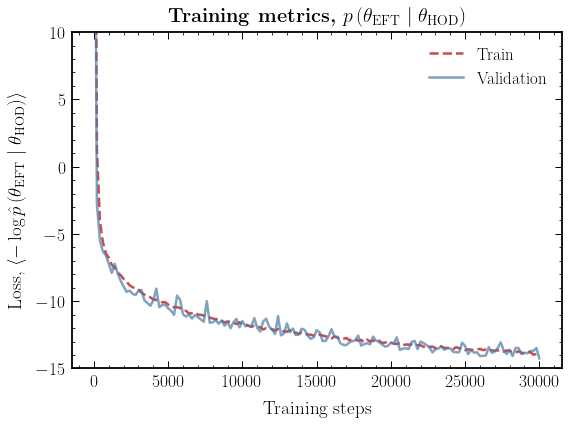

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(steps_accum, loss_train_accum, label="Train", ls='--')
ax.plot(steps_accum, loss_val_accum, label="Validation", alpha=0.7)
ax.set_xlabel("Training steps")
ax.set_ylabel(r"Loss, $\langle -\log \hat p\left(\theta_\mathrm{EFT}\mid\theta_\mathrm{HOD}\right)\rangle$")

ax.legend()
ax.set_title(r"\bf{Training metrics, $p\left(\theta_\mathrm{EFT}\mid\theta_\mathrm{HOD}\right)$}", y=1.01, fontsize=20)

ax.set_ylim(-15, 10)
plt.tight_layout()
plt.savefig("figures/loss_p_eft_hod.pdf")

In [216]:
samples_1 = flow.sample(context=(Y_val.mean(0) - 0 * Y_val.std(0)) [None, ...], num_samples=100_000)
samples_2 = flow.sample(context=(Y_val.mean(0) + 1 * Y_val.std(0)) [None, ...], num_samples=100_000)

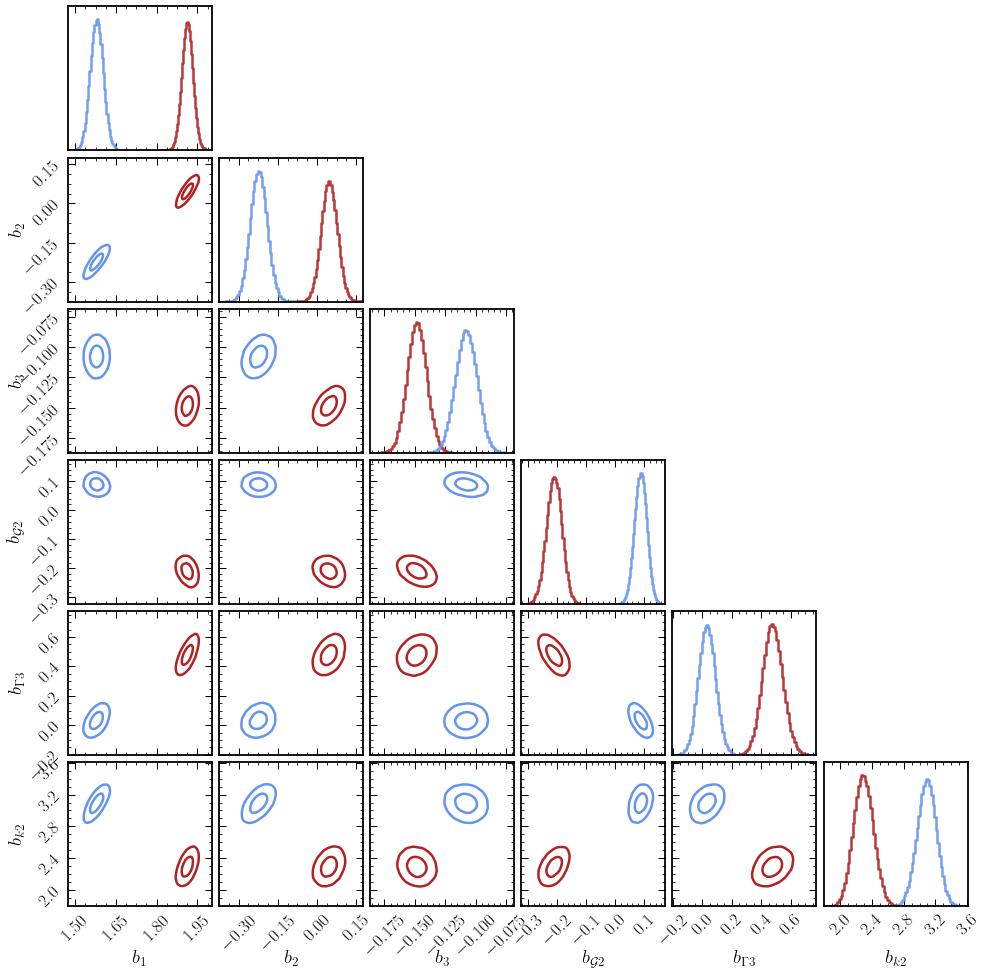

In [217]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 1.,
    "smooth1d": 0.75,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": False,
    "labels": [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$']
}

fig = corner.corner(samples_1.detach().numpy(), **corner_configs, color='firebrick');
corner.corner(samples_2.detach().numpy(), **corner_configs, fig=fig, color='cornflowerblue');

In [218]:
torch.save(flow, "../data/models/p_beta_hod.pt")

## $p(\beta)$

In [180]:
d_in = X_train.shape[-1]

flow = get_flow(d_in=d_in, d_context=0, d_hidden=64, n_layers=6, dropout=0.1)
steps_accum, loss_train_accum, loss_val_accum = train_flow(flow, X_train, None, X_val, None, batch_size=128, n_steps=30001, n_eval_every=200, lr=3e-4)

/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
  0%|          | 25/30001 [00:00<04:06, 121.78it/s]

Step 0, loss: 19.01, val loss: 18.83


  1%|          | 218/30001 [00:01<03:27, 143.24it/s]

Step 200, loss: 6.22, val loss: -0.48


  1%|▏         | 428/30001 [00:03<03:29, 140.91it/s]

Step 400, loss: -1.59, val loss: -2.05


  2%|▏         | 623/30001 [00:04<03:32, 137.95it/s]

Step 600, loss: -2.46, val loss: -2.50


  3%|▎         | 829/30001 [00:05<03:23, 143.61it/s]

Step 800, loss: -2.67, val loss: -2.75


  3%|▎         | 1025/30001 [00:07<03:21, 143.95it/s]

Step 1000, loss: -2.84, val loss: -2.88


  4%|▍         | 1220/30001 [00:08<03:26, 139.71it/s]

Step 1200, loss: -2.92, val loss: -2.95


  5%|▍         | 1414/30001 [00:10<03:34, 133.37it/s]

Step 1400, loss: -3.03, val loss: -3.05


  5%|▌         | 1622/30001 [00:11<03:25, 138.18it/s]

Step 1600, loss: -3.05, val loss: -3.11


  6%|▌         | 1826/30001 [00:13<03:29, 134.25it/s]

Step 1800, loss: -3.11, val loss: -3.20


  7%|▋         | 2027/30001 [00:14<03:33, 131.20it/s]

Step 2000, loss: -3.15, val loss: -3.18


  7%|▋         | 2227/30001 [00:15<03:25, 135.35it/s]

Step 2200, loss: -3.22, val loss: -3.10


  8%|▊         | 2424/30001 [00:17<03:19, 138.12it/s]

Step 2400, loss: -3.24, val loss: -3.25


  9%|▊         | 2620/30001 [00:18<03:13, 141.16it/s]

Step 2600, loss: -3.26, val loss: -3.31


  9%|▉         | 2815/30001 [00:20<03:12, 140.93it/s]

Step 2800, loss: -3.30, val loss: -3.29


 10%|█         | 3024/30001 [00:21<03:28, 129.16it/s]

Step 3000, loss: -3.34, val loss: -3.38


 11%|█         | 3215/30001 [00:23<03:09, 141.27it/s]

Step 3200, loss: -3.36, val loss: -2.98


 11%|█▏        | 3426/30001 [00:24<03:03, 144.58it/s]

Step 3400, loss: -3.38, val loss: -3.45


 12%|█▏        | 3622/30001 [00:25<03:03, 143.78it/s]

Step 3600, loss: -3.41, val loss: -3.50


 13%|█▎        | 3816/30001 [00:27<03:23, 128.92it/s]

Step 3800, loss: -3.41, val loss: -3.46


 13%|█▎        | 4026/30001 [00:28<02:58, 145.58it/s]

Step 4000, loss: -3.45, val loss: -3.46


 14%|█▍        | 4222/30001 [00:30<03:00, 143.18it/s]

Step 4200, loss: -3.45, val loss: -3.52


 15%|█▍        | 4417/30001 [00:31<03:01, 140.96it/s]

Step 4400, loss: -3.50, val loss: -3.56


 15%|█▌        | 4628/30001 [00:33<02:54, 145.08it/s]

Step 4600, loss: -3.48, val loss: -3.54


 16%|█▌        | 4824/30001 [00:34<02:59, 140.47it/s]

Step 4800, loss: -3.47, val loss: -3.50


 17%|█▋        | 5017/30001 [00:35<02:56, 141.18it/s]

Step 5000, loss: -3.51, val loss: -3.42


 17%|█▋        | 5227/30001 [00:37<02:52, 143.55it/s]

Step 5200, loss: -3.55, val loss: -3.62


 18%|█▊        | 5422/30001 [00:38<02:50, 144.27it/s]

Step 5400, loss: -3.55, val loss: -3.57


 19%|█▊        | 5617/30001 [00:39<02:56, 138.37it/s]

Step 5600, loss: -3.54, val loss: -3.56


 19%|█▉        | 5828/30001 [00:41<02:49, 142.49it/s]

Step 5800, loss: -3.58, val loss: -3.54


 20%|██        | 6024/30001 [00:42<02:45, 144.58it/s]

Step 6000, loss: -3.57, val loss: -3.51


 21%|██        | 6220/30001 [00:44<02:44, 144.48it/s]

Step 6200, loss: -3.62, val loss: -3.65


 21%|██▏       | 6430/30001 [00:45<02:42, 144.61it/s]

Step 6400, loss: -3.63, val loss: -3.58


 22%|██▏       | 6625/30001 [00:46<02:41, 144.65it/s]

Step 6600, loss: -3.61, val loss: -3.64


 23%|██▎       | 6822/30001 [00:48<02:38, 146.20it/s]

Step 6800, loss: -3.63, val loss: -3.73


 23%|██▎       | 7021/30001 [00:49<02:39, 143.78it/s]

Step 7000, loss: -3.62, val loss: -3.67


 24%|██▍       | 7216/30001 [00:51<02:41, 141.08it/s]

Step 7200, loss: -3.63, val loss: -3.71


 25%|██▍       | 7426/30001 [00:52<02:39, 141.73it/s]

Step 7400, loss: -3.67, val loss: -3.69


 25%|██▌       | 7617/30001 [00:53<02:46, 134.49it/s]

Step 7600, loss: -3.68, val loss: -3.74


 26%|██▌       | 7821/30001 [00:55<02:37, 141.25it/s]

Step 7800, loss: -3.63, val loss: -3.60


 27%|██▋       | 8016/30001 [00:56<02:35, 141.13it/s]

Step 8000, loss: -3.67, val loss: -3.72


 27%|██▋       | 8226/30001 [00:58<02:33, 142.01it/s]

Step 8200, loss: -3.65, val loss: -3.77


 28%|██▊       | 8420/30001 [00:59<02:34, 139.54it/s]

Step 8400, loss: -3.68, val loss: -3.77


 29%|██▉       | 8629/30001 [01:01<02:29, 142.68it/s]

Step 8600, loss: -3.70, val loss: -3.70


 29%|██▉       | 8823/30001 [01:02<02:29, 142.12it/s]

Step 8800, loss: -3.69, val loss: -3.76


 30%|███       | 9019/30001 [01:03<02:26, 142.89it/s]

Step 9000, loss: -3.72, val loss: -3.82


 31%|███       | 9215/30001 [01:05<02:29, 139.41it/s]

Step 9200, loss: -3.71, val loss: -3.81


 31%|███▏      | 9415/30001 [01:06<02:37, 131.09it/s]

Step 9400, loss: -3.71, val loss: -3.79


 32%|███▏      | 9623/30001 [01:08<02:48, 120.97it/s]

Step 9600, loss: -3.66, val loss: -3.82


 33%|███▎      | 9820/30001 [01:09<02:27, 136.81it/s]

Step 9800, loss: -3.74, val loss: -3.79


 33%|███▎      | 10026/30001 [01:11<02:23, 139.42it/s]

Step 10000, loss: -3.73, val loss: -3.61


 34%|███▍      | 10219/30001 [01:12<02:19, 141.77it/s]

Step 10200, loss: -3.71, val loss: -3.86


 35%|███▍      | 10429/30001 [01:14<02:15, 144.95it/s]

Step 10400, loss: -3.74, val loss: -3.80


 35%|███▌      | 10624/30001 [01:15<02:18, 140.32it/s]

Step 10600, loss: -3.75, val loss: -3.71


 36%|███▌      | 10818/30001 [01:17<02:26, 131.21it/s]

Step 10800, loss: -3.72, val loss: -3.84


 37%|███▋      | 11027/30001 [01:18<02:14, 140.92it/s]

Step 11000, loss: -3.76, val loss: -3.74


 37%|███▋      | 11222/30001 [01:19<02:10, 143.66it/s]

Step 11200, loss: -3.79, val loss: -3.88


 38%|███▊      | 11416/30001 [01:21<02:12, 139.99it/s]

Step 11400, loss: -3.77, val loss: -3.74


 39%|███▉      | 11626/30001 [01:22<02:07, 144.62it/s]

Step 11600, loss: -3.79, val loss: -3.85


 39%|███▉      | 11815/30001 [01:24<02:15, 133.82it/s]

Step 11800, loss: -3.80, val loss: -3.85


 40%|████      | 12026/30001 [01:25<02:04, 144.48it/s]

Step 12000, loss: -3.76, val loss: -3.86


 41%|████      | 12221/30001 [01:26<02:20, 126.59it/s]

Step 12200, loss: -3.79, val loss: -3.87


 41%|████▏     | 12427/30001 [01:28<02:09, 135.61it/s]

Step 12400, loss: -3.79, val loss: -3.88


 42%|████▏     | 12621/30001 [01:29<02:02, 142.16it/s]

Step 12600, loss: -3.78, val loss: -3.85


 43%|████▎     | 12816/30001 [01:31<02:01, 142.02it/s]

Step 12800, loss: -3.81, val loss: -3.87


 43%|████▎     | 13025/30001 [01:32<02:02, 138.30it/s]

Step 13000, loss: -3.81, val loss: -3.83


 44%|████▍     | 13224/30001 [01:34<02:07, 131.65it/s]

Step 13200, loss: -3.81, val loss: -3.87


 45%|████▍     | 13423/30001 [01:35<01:57, 140.90it/s]

Step 13400, loss: -3.81, val loss: -3.87


 45%|████▌     | 13619/30001 [01:37<01:51, 146.44it/s]

Step 13600, loss: -3.81, val loss: -3.77


 46%|████▌     | 13830/30001 [01:38<01:51, 144.96it/s]

Step 13800, loss: -3.84, val loss: -3.93


 47%|████▋     | 14027/30001 [01:39<01:51, 142.77it/s]

Step 14000, loss: -3.82, val loss: -3.88


 47%|████▋     | 14222/30001 [01:41<01:48, 146.08it/s]

Step 14200, loss: -3.84, val loss: -3.87


 48%|████▊     | 14419/30001 [01:42<01:47, 145.62it/s]

Step 14400, loss: -3.83, val loss: -3.92


 49%|████▉     | 14630/30001 [01:44<01:47, 143.42it/s]

Step 14600, loss: -3.88, val loss: -3.82


 49%|████▉     | 14818/30001 [01:45<01:56, 130.01it/s]

Step 14800, loss: -3.85, val loss: -3.90


 50%|█████     | 15014/30001 [01:46<01:54, 130.54it/s]

Step 15000, loss: -3.82, val loss: -3.94


 51%|█████     | 15216/30001 [01:48<01:53, 130.32it/s]

Step 15200, loss: -3.81, val loss: -3.94


 51%|█████▏    | 15411/30001 [01:49<01:47, 135.51it/s]

Step 15400, loss: -3.87, val loss: -3.92


 52%|█████▏    | 15629/30001 [01:51<01:40, 143.48it/s]

Step 15600, loss: -3.88, val loss: -3.91


 53%|█████▎    | 15817/30001 [01:52<01:36, 147.35it/s]

Step 15800, loss: -3.87, val loss: -3.87


 53%|█████▎    | 16022/30001 [01:54<01:43, 134.57it/s]

Step 16000, loss: -3.82, val loss: -3.97


 54%|█████▍    | 16229/30001 [01:55<01:35, 143.90it/s]

Step 16200, loss: -3.88, val loss: -3.93


 55%|█████▍    | 16424/30001 [01:56<01:34, 143.73it/s]

Step 16400, loss: -3.90, val loss: -3.90


 55%|█████▌    | 16620/30001 [01:58<01:35, 139.98it/s]

Step 16600, loss: -3.88, val loss: -3.84


 56%|█████▌    | 16830/30001 [01:59<01:30, 145.62it/s]

Step 16800, loss: -3.84, val loss: -3.66


 57%|█████▋    | 17026/30001 [02:01<01:29, 145.43it/s]

Step 17000, loss: -3.88, val loss: -3.94


 57%|█████▋    | 17222/30001 [02:02<01:27, 145.28it/s]

Step 17200, loss: -3.90, val loss: -3.90


 58%|█████▊    | 17417/30001 [02:03<01:26, 145.10it/s]

Step 17400, loss: -3.88, val loss: -3.97


 59%|█████▉    | 17629/30001 [02:05<01:24, 146.41it/s]

Step 17600, loss: -3.91, val loss: -3.96


 59%|█████▉    | 17825/30001 [02:06<01:25, 142.34it/s]

Step 17800, loss: -3.89, val loss: -3.99


 60%|██████    | 18019/30001 [02:08<01:28, 135.54it/s]

Step 18000, loss: -3.89, val loss: -3.85


 61%|██████    | 18219/30001 [02:09<01:32, 126.73it/s]

Step 18200, loss: -3.90, val loss: -3.93


 61%|██████▏   | 18426/30001 [02:11<01:30, 127.60it/s]

Step 18400, loss: -3.92, val loss: -3.99


 62%|██████▏   | 18619/30001 [02:12<01:25, 133.14it/s]

Step 18600, loss: -3.93, val loss: -3.91


 63%|██████▎   | 18828/30001 [02:14<01:19, 140.00it/s]

Step 18800, loss: -3.94, val loss: -4.02


 63%|██████▎   | 19026/30001 [02:15<01:17, 140.97it/s]

Step 19000, loss: -3.90, val loss: -3.96


 64%|██████▍   | 19223/30001 [02:16<01:13, 146.30it/s]

Step 19200, loss: -3.92, val loss: -3.92


 65%|██████▍   | 19421/30001 [02:18<01:12, 145.64it/s]

Step 19400, loss: -3.91, val loss: -3.99


 65%|██████▌   | 19617/30001 [02:19<01:11, 145.04it/s]

Step 19600, loss: -3.92, val loss: -3.91


 66%|██████▌   | 19817/30001 [02:20<01:09, 147.53it/s]

Step 19800, loss: -3.96, val loss: -3.99


 67%|██████▋   | 20031/30001 [02:22<01:07, 147.39it/s]

Step 20000, loss: -3.93, val loss: -3.98


 67%|██████▋   | 20216/30001 [02:23<01:07, 144.07it/s]

Step 20200, loss: -3.94, val loss: -3.91


 68%|██████▊   | 20428/30001 [02:24<01:05, 145.98it/s]

Step 20400, loss: -3.96, val loss: -4.04


 69%|██████▉   | 20627/30001 [02:26<01:04, 144.88it/s]

Step 20600, loss: -3.96, val loss: -3.91


 69%|██████▉   | 20824/30001 [02:27<01:08, 133.13it/s]

Step 20800, loss: -3.94, val loss: -4.02


 70%|███████   | 21018/30001 [02:29<01:01, 144.90it/s]

Step 21000, loss: -3.95, val loss: -3.93


 71%|███████   | 21228/30001 [02:30<01:02, 139.98it/s]

Step 21200, loss: -3.93, val loss: -3.94


 71%|███████▏  | 21426/30001 [02:31<00:58, 146.97it/s]

Step 21400, loss: -3.97, val loss: -3.99


 72%|███████▏  | 21622/30001 [02:33<00:59, 140.90it/s]

Step 21600, loss: -3.94, val loss: -4.04


 73%|███████▎  | 21815/30001 [02:34<01:00, 135.81it/s]

Step 21800, loss: -3.98, val loss: -3.99


 73%|███████▎  | 22022/30001 [02:36<00:56, 140.58it/s]

Step 22000, loss: -3.98, val loss: -4.02


 74%|███████▍  | 22220/30001 [02:37<00:53, 145.36it/s]

Step 22200, loss: -3.89, val loss: -4.06


 75%|███████▍  | 22418/30001 [02:38<00:52, 145.71it/s]

Step 22400, loss: -3.96, val loss: -3.96


 75%|███████▌  | 22629/30001 [02:40<00:53, 138.80it/s]

Step 22600, loss: -3.96, val loss: -3.88


 76%|███████▌  | 22824/30001 [02:41<00:50, 142.21it/s]

Step 22800, loss: -3.96, val loss: -4.07


 77%|███████▋  | 23028/30001 [02:43<00:50, 136.79it/s]

Step 23000, loss: -4.00, val loss: -4.02


 77%|███████▋  | 23227/30001 [02:44<00:47, 141.75it/s]

Step 23200, loss: -3.99, val loss: -4.01


 78%|███████▊  | 23423/30001 [02:46<00:46, 140.75it/s]

Step 23400, loss: -3.95, val loss: -4.04


 79%|███████▊  | 23619/30001 [02:47<00:44, 143.32it/s]

Step 23600, loss: -3.97, val loss: -4.00


 79%|███████▉  | 23817/30001 [02:48<00:43, 141.32it/s]

Step 23800, loss: -3.99, val loss: -4.05


 80%|████████  | 24030/30001 [02:50<00:40, 146.66it/s]

Step 24000, loss: -3.99, val loss: -4.06


 81%|████████  | 24230/30001 [02:51<00:39, 146.34it/s]

Step 24200, loss: -4.02, val loss: -4.02


 81%|████████▏ | 24426/30001 [02:52<00:40, 136.54it/s]

Step 24400, loss: -4.02, val loss: -4.00


 82%|████████▏ | 24620/30001 [02:54<00:37, 143.17it/s]

Step 24600, loss: -4.02, val loss: -3.97


 83%|████████▎ | 24830/30001 [02:55<00:36, 143.02it/s]

Step 24800, loss: -4.01, val loss: -4.03


 83%|████████▎ | 25025/30001 [02:57<00:37, 131.66it/s]

Step 25000, loss: -4.04, val loss: -4.00


 84%|████████▍ | 25220/30001 [02:58<00:34, 139.82it/s]

Step 25200, loss: -4.03, val loss: -4.08


 85%|████████▍ | 25430/30001 [03:00<00:32, 142.21it/s]

Step 25400, loss: -4.01, val loss: -4.10


 85%|████████▌ | 25625/30001 [03:01<00:31, 141.16it/s]

Step 25600, loss: -3.99, val loss: -4.10


 86%|████████▌ | 25821/30001 [03:02<00:28, 144.20it/s]

Step 25800, loss: -4.05, val loss: -4.05


 87%|████████▋ | 26017/30001 [03:04<00:27, 145.35it/s]

Step 26000, loss: -4.02, val loss: -4.04


 87%|████████▋ | 26228/30001 [03:05<00:26, 143.82it/s]

Step 26200, loss: -4.01, val loss: -4.08


 88%|████████▊ | 26422/30001 [03:06<00:25, 137.99it/s]

Step 26400, loss: -4.00, val loss: -4.03


 89%|████████▊ | 26616/30001 [03:08<00:23, 142.32it/s]

Step 26600, loss: -4.01, val loss: -3.91


 89%|████████▉ | 26827/30001 [03:09<00:22, 140.75it/s]

Step 26800, loss: -4.03, val loss: -3.99


 90%|█████████ | 27019/30001 [03:11<00:21, 141.36it/s]

Step 27000, loss: -4.01, val loss: -4.00


 91%|█████████ | 27230/30001 [03:12<00:19, 143.93it/s]

Step 27200, loss: -4.04, val loss: -4.07


 91%|█████████▏| 27425/30001 [03:13<00:18, 140.37it/s]

Step 27400, loss: -4.06, val loss: -4.09


 92%|█████████▏| 27620/30001 [03:15<00:16, 140.21it/s]

Step 27600, loss: -4.03, val loss: -3.89


 93%|█████████▎| 27830/30001 [03:16<00:15, 142.28it/s]

Step 27800, loss: -4.01, val loss: -4.08


 93%|█████████▎| 28019/30001 [03:18<00:14, 138.80it/s]

Step 28000, loss: -4.05, val loss: -4.14


 94%|█████████▍| 28228/30001 [03:19<00:12, 141.18it/s]

Step 28200, loss: -4.08, val loss: -4.02


 95%|█████████▍| 28427/30001 [03:21<00:12, 129.92it/s]

Step 28400, loss: -4.02, val loss: -4.10


 95%|█████████▌| 28617/30001 [03:22<00:09, 143.67it/s]

Step 28600, loss: -4.03, val loss: -4.06


 96%|█████████▌| 28831/30001 [03:23<00:08, 144.48it/s]

Step 28800, loss: -4.01, val loss: -4.08


 97%|█████████▋| 29025/30001 [03:25<00:07, 136.27it/s]

Step 29000, loss: -4.06, val loss: -4.03


 97%|█████████▋| 29217/30001 [03:26<00:05, 142.67it/s]

Step 29200, loss: -4.06, val loss: -4.12


 98%|█████████▊| 29427/30001 [03:28<00:03, 143.77it/s]

Step 29400, loss: -4.08, val loss: -4.02


 99%|█████████▊| 29621/30001 [03:29<00:02, 131.51it/s]

Step 29600, loss: -4.06, val loss: -4.08


 99%|█████████▉| 29830/30001 [03:31<00:01, 142.91it/s]

Step 29800, loss: -4.03, val loss: -4.09


100%|██████████| 30001/30001 [03:32<00:00, 141.31it/s]

Step 30000, loss: -4.06, val loss: -4.09


In [181]:
flow.eval();

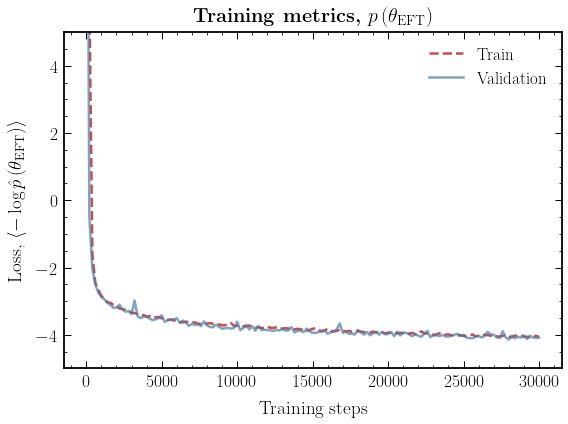

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(steps_accum, loss_train_accum, label="Train", ls='--')
ax.plot(steps_accum, loss_val_accum, label="Validation", alpha=0.7)
ax.set_xlabel("Training steps")
ax.set_ylabel(r"Loss, $\langle -\log \hat p\left(\theta_\mathrm{EFT}\right)\rangle$")

ax.legend()
ax.set_title(r"\bf{Training metrics, $p\left(\theta_\mathrm{EFT}\right)$}", y=1.01, fontsize=20)

ax.set_ylim(-5, 5)

plt.tight_layout()
plt.savefig("figures/loss_p_eft.pdf")

In [183]:
samples = flow.sample(num_samples=100_000)

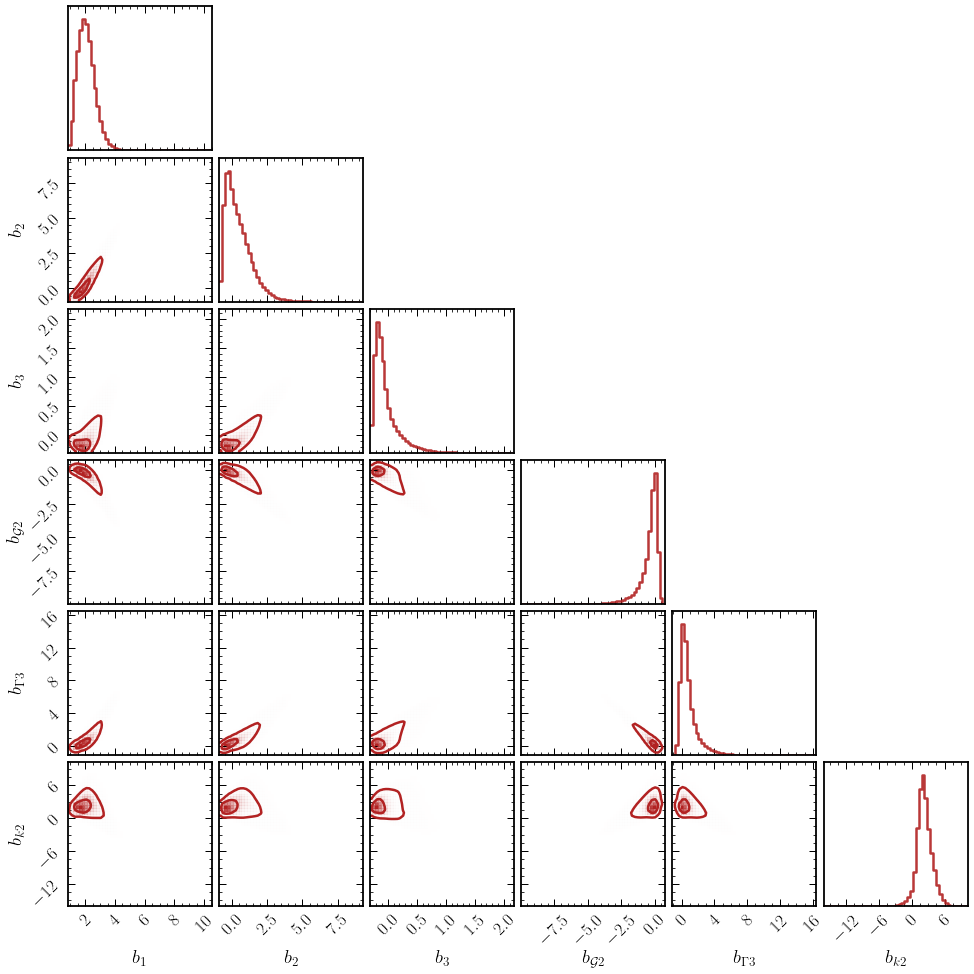

In [184]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 0.75,
    "smooth1d": 0.5,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": True,
    "labels": [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$']
}

fig = corner.corner(samples.detach().numpy(), **corner_configs, color='firebrick');

In [185]:
torch.save(flow, "../data/models/p_beta.pt")